# Newton's method

---

### Given $g: \mathbb{R}^N\rightarrow \mathbb{R}^k$, $x\in \mathbb{R}^N$, $v \in \mathbb{R}^{N\times k}$ find $\lambda\in \mathbb{R}^k$, such that  
$$
\begin{aligned}
   g(x + \tau v \lambda) = 0 
   \end{aligned}
$$

### Netwon's method

$$
\lambda_{n+1} = \lambda_n - \tau^{-1}(\nabla g(x_n + \tau v\lambda_n) v)^{-1} g(x_n + \tau v \lambda_n)
$$



### First, load neceesary packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
import itertools 
from tqdm import tqdm
import os
import time

In [ ]:
def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = torch.nn.Sequential()
    for i in range(len(layer_dims)-2) :
        layers.add_module(f'{i+1}',torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.add_module(f'acti {i+1}', activation)
    layers.add_module('last', torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    return layers

### Test cases

In [41]:
class func_g:
    def __init__(self, X, y=1):
        self.k = 1
        self.y = y
        self.X = X
    def __call__(self, model):
        Z = model(self.X)
        tmp = ((Z**2).sum()-self.y).reshape((1))
        return tmp
    
class Simple(torch.nn.Module):
    def __init__(self):
        super(Simple, self).__init__()
        self.x = torch.nn.Parameter(torch.tensor([3.0, 1.0]))
    def forward(self, X):
        return X.sum()
    
class simple_f():
    def __init__(self):
        pass
    def __call__(self, model, X):
        return model.x[0] + model.x[1]

class simple_g():
    def __init__(self):
        self.k = 1
    def __call__(self, model):
        return 0.5 * (model.x[0]**2 + model.x[1]**2 - 1.0).reshape((1))

### Optimizer

In [48]:
          
class ConstrainedOptimizer():
    
    def __init__(self, model, g=None, tau=1e-1, res_tol=1e-3, max_newton_steps=100, verbose=True):
        self.g = g
        self.tau = tau
        self.res_tol = res_tol
        self.max_newton_steps = max_newton_steps
        self.verbose = verbose
        self.model = model
        
    def reset_g(self, g):
        self.g = g
        
    def update(self, loss):
        grad_f = torch.autograd.grad(loss, self.model.parameters())
        with torch.no_grad():
            for param, grad in zip(self.model.parameters(), grad_f):
                param.add_(-1.0 * grad * self.tau)       
                            
    def projection(self):       
        iter_step = 0
        self.converged = False
        self.projection_iter_steps = 0 
        
        g_val = self.g(self.model)
        k = len(g_val)
        grad_v = [torch.autograd.grad(g_val[idx], self.model.parameters(), 
                                      create_graph=True, retain_graph=True) for idx in range(k)] 

        while iter_step < self.max_newton_steps:
            g_now = self.g(self.model)
            if self.verbose:
                print (f'projection step={iter_step}, g={g_now.detach().item():.3e}')

            if torch.linalg.norm(g_now) < self.res_tol:
                self.converged = True
                break

            grad_g = [torch.autograd.grad(g_now[idx], self.model.parameters(), 
                                          create_graph=True, retain_graph=True) for idx in range(k)] 
            with torch.no_grad():
                mat = np.zeros((k, k))
                for i in range(k):
                    for j in range(k):
                        for z1, z2 in zip(grad_g[i], grad_v[j]):
                            mat[i,j] += (z1 * z2).sum()
                #print ('mat=', mat)
                dlam = -1.0 * np.linalg.solve(mat, g_now.numpy()) / self.tau

                for i in range(k):
                    for param, z2 in zip(self.model.parameters(), grad_v[i]):
                        param.add_(z2 * dlam[i] * self.tau)

            iter_step += 1
        if self.verbose:
            print (f'total iteration steps for projection: {iter_step}.')
            if not self.converged:
                print (f'Warning: the residual {self.res_tol:.3e} not achieved in projection step.')
                
        self.projection_iter_steps = iter_step
        
    def is_succeed(self):
        return self.converged
    
    def projection_steps(self):
        return self.projection_iter_steps

    def step(self, loss):
        self.update(loss)
        self.projection()

### Test 1

In [49]:
# Test 1

layer_dims = [2, 5, 5, 1] 

model = create_sequential_nn(layer_dims)

X = torch.tensor(np.random.rand(100, 2)).float() 
g = func_g(X, 2.0)

opt = ConstrainedOptimizer(model, g)

#print (grad_v)
opt.projection()

print (opt.is_succeed(), opt.projection_steps())
gg = g(model)
print ('gg=', gg)

projection step=0, g=-1.085e+00
projection step=1, g=3.817e-01
projection step=2, g=1.642e-02
projection step=3, g=3.600e-05
total iteration steps for projection: 3.
True 3
gg= tensor([3.6001e-05], grad_fn=<ReshapeAliasBackward0>)


### Test 2

In [52]:
model = Simple()
opt = ConstrainedOptimizer(model, verbose=False)

n_steps = 40
for idx in range(n_steps):
    loss = simple_f()(model, None)
    g = simple_g()
    opt.reset_g(g)
    opt.step(loss)
    print (f'step={idx}, loss={loss.detach().numpy()}')

print (model.x)

step=0, loss=4.0
step=1, loss=1.2515074014663696
step=2, loss=1.1985273361206055
step=3, loss=1.1303766965866089
step=4, loss=1.0441495180130005
step=5, loss=0.9372556805610657
step=6, loss=0.8079961538314819
step=7, loss=0.6562255620956421
step=8, loss=0.4839351773262024
step=9, loss=0.29574263095855713
step=10, loss=0.09761041402816772
step=11, loss=-0.1023896336555481
step=12, loss=-0.29638993740081787
step=13, loss=-0.47807154059410095
step=14, loss=-0.6415536403656006
step=15, loss=-0.7853312492370605
step=16, loss=-0.9082034826278687
step=17, loss=-1.0109602212905884
step=18, loss=-1.0953741073608398
step=19, loss=-1.1637217998504639
step=20, loss=-1.2184215784072876
step=21, loss=-1.2617963552474976
step=22, loss=-1.2959414720535278
step=23, loss=-1.322668194770813
step=24, loss=-1.34349524974823
step=25, loss=-1.3596689701080322
step=26, loss=-1.3721956014633179
step=27, loss=-1.3818774223327637
step=28, loss=-1.3893485069274902
step=29, loss=-1.395106554031372
step=30, loss=-1

In [ ]:
def sample_data_domain(size):
    return np.random.rand(size, 2) 

def sample_data_boundary(size_each_bndry):
    # left boundary
    data_whole = np.column_stack([np.zeros(size_each_bndry), np.random.rand(size_each_bndry)]) 
    # right boundary
    data = np.column_stack([np.ones(size_each_bndry), np.random.rand(size_each_bndry)]) 
    data_whole = np.concatenate([data_whole, data])
    # top boundary
    data = np.column_stack([np.random.rand(size_each_bndry),np.ones(size_each_bndry)]) 
    data_whole = np.concatenate([data_whole, data])   
    # bottom boundary
    data = np.column_stack([np.random.rand(size_each_bndry),np.zeros(size_each_bndry)])     
    data_whole = np.concatenate([data_whole, data])
    
    return data_whole

### The training function

In [ ]:
    def train(model, X, Y, optimizer, learning_rate, batch_size_X, batch_size_Y, num_iters, alpha):
        """Function to train the model
        """
         
        # --- start the training over the required number of epochs ---
        train_losses = []
        
        print ("\ntraining starts, %d iterations in total." % num_iters) 
        rng = np.random.default_rng()
        for iter in tqdm(range(num_iters)):
            # Train the model by going through the whole dataset
            batch_idx_X = rng.integers(X.shape[0], size=batch_size_X)
            batch_idx_Y = rng.integers(Y.shape[0], size=batch_size_Y)
            
            X_batch = torch.tensor(X[batch_idx_X, :], requires_grad=True).float()
            Y_batch = torch.tensor(Y[batch_idx_Y, :]).float()
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
           
            loss1 = pde_loss(model, X_batch)
            loss2 = boundary_loss(model, Y_batch)

            loss = loss1 + alpha * loss2
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Store loss
            loss3 = ((model(X_batch) - ref_u(X_batch))**2).mean()

            train_losses.append([loss.detach().item(), loss1.detach().item(), loss2.detach().item(), loss3.detach().item()])
            # Updating parameters
            optimizer.step()
        print ("training ends.\n") 
        return model, train_losses

### Set parameters

In [ ]:
n = 10000
n_bndry = 1000

batch_size = 100
batch_size_bndry = 100

# penalty constant
alpha = 5.0
# total number of learning steps
num_iters = 2000
# layers of the neural network.
layer_dims = [2, 20, 20, 20, 1] 
optimizer_name = 'Adam'
learning_rate = 0.01

# create neural network that represents the solution of the PDE
model = create_sequential_nn(layer_dims)

# prepare data
X = sample_data_domain(n)
Y = sample_data_boundary(n_bndry)

# prepare optimizer
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Start training

In [ ]:
trained_model, loss_list = train(model, X, Y, optimizer, learning_rate, batch_size, batch_size_bndry, num_iters, alpha)
loss_list = np.array(loss_list)


training starts, 2000 iterations in total.


100%|██████████| 2000/2000 [00:09<00:00, 204.41it/s]

training ends.



### Plot the solution

Losses:


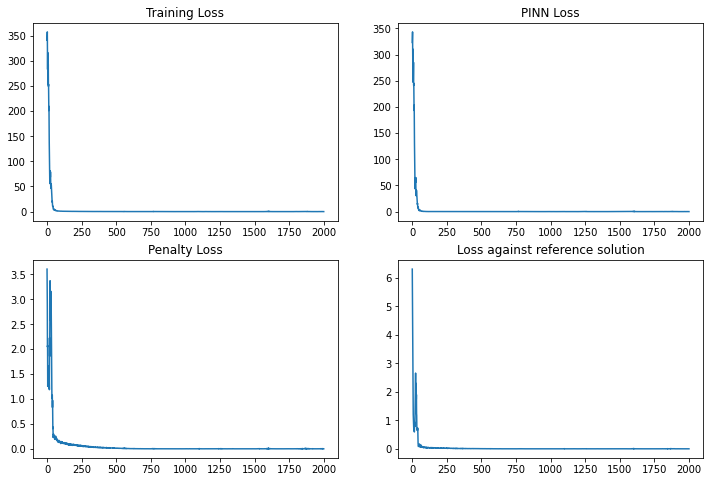

Solution u:


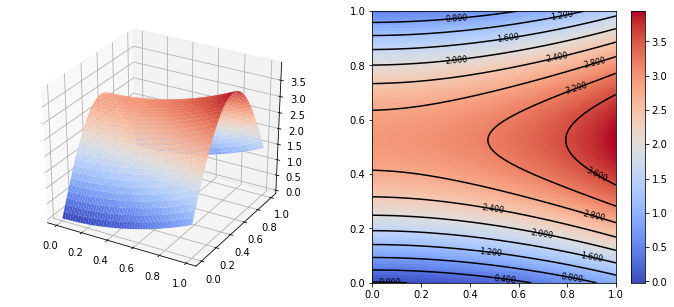

In [ ]:
ngrid = 100
grid1d = np.linspace(0, 1.0, ngrid)
x_plot = np.outer(grid1d, np.ones(ngrid)) 
y_plot = np.outer(grid1d, np.ones(ngrid)).T 

x2d = torch.from_numpy(np.concatenate((x_plot.reshape(ngrid * ngrid, 1), y_plot.reshape(ngrid * ngrid, 1)), axis=1)).float()
u = trained_model(x2d).detach().numpy()

u = u.reshape(ngrid, ngrid)

print ('Losses:')
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(loss_list[:,0])
ax[0,0].set_title('Training Loss')
ax[0,1].plot(loss_list[:,1])
ax[0,1].set_title('PINN Loss')
ax[1,0].plot(loss_list[:,2])
ax[1,0].set_title('Penalty Loss')
ax[1,1].plot(loss_list[:,3])
ax[1,1].set_title('Loss against reference solution')

plt.show()
fig_name = f'losses.jpg'
#fig.savefig(fig_name)
plt.close()

print ('Solution u:')

fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)  
ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
ax1.clabel(contours, inline=False, fontsize=8)
fig.colorbar(im, ax=ax1)
fig_name = f'u.jpg'
#fig.savefig(fig_name)
plt.show()
#plt.close()
